## Matapath2vec

Metapath2vec [[1]](#fn1) extends the idea of DeepWalk and node2vec to heterogeneous networks. It introduces meta-path based random walks to generate heterogeneous neighborhoods. This way, it is naturally able to outpeform algorithms which ignore heterogeneous nature of graphs, such as node2vec because heterogeneous random walks are biased to highly visible types of nodes and concetrated nodes. Therefore, metapath2vec uses meta-path-based random walk strategy to ensure that the semantic relationships can be incorporated into the skip-gram model.

As an example of a well known and easily understandable heterogeneous network we will use a citation network from the ArnetMiner project [[2]](#fn2) which provides a selection of large citation networks compiled from sources such as DBLP and ACM. We will use  the DBLP citation network version 10 which is one of the newer networks conveniently stored in JSON format.

The following packages are required to run this notebook:

- stellargraph==1.2.1
- networkx==2.5
- remotezip-0.9.2
- pyx==0.15

-----
<span id="fn1"> [1] Yuxiao Dong, Nitesh V. Chawla, and Ananthram Swami. 2017. Metapath2vec: Scalable Representation Learning for Heterogeneous Networks. In Proceedings of the 23rd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD '17). Association for Computing Machinery, New York, NY, USA, 135–144. </span>

<span id="fn2"> [2] Jie Tang, Jing Zhang, Limin Yao, Juanzi Li, Li Zhang, and Zhong Su. ArnetMiner: Extraction and Mining of Academic Social Networks. In Proceedings of the Fourteenth ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (SIGKDD'2008). pp.990-998. </span>

-----

The complete [DBLP-Citation-network V10](https://www.aminer.cn/citation) is a 1.7GB zip file which contains node and edge descriptions in JSON format of a graph with more than 3M nodes and 25M edges. We will use only a minor part which is stored in the file `dblp-ref/dblp-ref-3.json` inside the archive.

In [1]:
from remotezip import RemoteZip
import json
import os

if not os.path.exists('data/dblp-ref-3.json'):
    with RemoteZip('https://lfs.aminer.cn/lab-datasets/citation/dblp.v10.zip') as zip:
        with zip.open('dblp-ref/dblp-ref-3.json') as dblp:
            with open('data/dblp-ref-3.json', 'w') as ofp:
                ofp.write(dblp.read().decode('utf-8'))
          
with open('data/dblp-ref-3.json') as fp:
    lines = [json.loads(line) for line in fp if line]
print(len(lines))

79007


Every line in the file is a JSON object containing some or all of the following attributes: id, title, authors, venue, year, n_citation, references, and abstract. We will build a network accoding to the following schema.

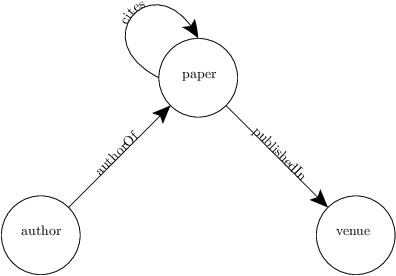

In [2]:
from pyx import *
h = 0.707
c = canvas.canvas()
c.stroke(path.circle(4, 4, 1))
c.stroke(path.circle(8, 0, 1))
c.stroke(path.circle(0, 0, 1))
c.stroke(path.line(h, h, 4-h, 4-h), [deco.earrow(size=0.5), deco.curvedtext("authorOf")])
c.stroke(path.line(4+h, 4-h, 8-h, h), [deco.earrow(size=0.5), deco.curvedtext("publishedIn")])
c.stroke(path.curve(3, 4, 1, 5, 3, 7, 4,5), [deco.earrow(size=0.5), deco.curvedtext("cites")])
c.text(-0.5, 0, 'author')
c.text(3.6, 4, 'paper')
c.text(7.5, 0, 'venue')
c

Let's transform the input data into a network. We will create an empty directed network and populate it with nodes and edges according to the input data. We will consider only complete data, i.e., the venue, authors and references must be present. Also, we will ignore references to papers not present in our subset.

In [3]:
import networkx as nx
g = nx.DiGraph()
paper_ids = set()
venues = set()
authors = set()
for line in lines:
    if 'references' in line and line['venue'] and line['authors']:
        paper_ids.add(line['id'])
for line in lines:
    if 'references' in line and line['venue'] and line['authors']:
        if line['id'] in paper_ids:
            g.add_node(line['id'], label='paper')
            for author in line['authors']:
                g.add_node(author, label='author')
                g.add_edge(author, line['id'], label='authorOf') 
                authors.add(author)

            g.add_node(line['venue'], label='venue')
            g.add_edge(line['id'], line['venue'], label='publishedIn')
            venues.add(line['venue'])

            for cited in line['references']:
                if cited in paper_ids:
                    g.add_node(cited, label='paper')
                    g.add_edge(line['id'], cited, label='cites')
print(g.number_of_nodes(), g.number_of_edges())

134784 170296


We will also ignore all weakly connected components except the largest one.

In [4]:
from collections import Counter
from pprint import pprint
cc_sizes = Counter()
for cc in nx.weakly_connected_components(g):
    cc_sizes[len(cc)] += 1
pprint(sorted(cc_sizes.items()))
max_cc = max(nx.weakly_connected_components(g), key=len)    
g = g.subgraph(max_cc).copy()
print(f'V={g.number_of_nodes()}, E={g.number_of_edges()}, density: {nx.density(g):.6f}')

[(3, 30),
 (4, 57),
 (5, 43),
 (6, 24),
 (7, 17),
 (8, 8),
 (9, 7),
 (10, 13),
 (11, 10),
 (12, 4),
 (13, 4),
 (14, 4),
 (15, 2),
 (16, 1),
 (17, 2),
 (18, 3),
 (19, 1),
 (20, 1),
 (21, 1),
 (23, 1),
 (24, 1),
 (26, 1),
 (27, 1),
 (35, 1),
 (37, 1),
 (38, 1),
 (53, 1),
 (133008, 1)]
V=133008, E=168749, density: 0.000010


In order to run metapath2vec we first need to load the graph into the `StellarGraph` data structure.

In [5]:
import stellargraph
sg = stellargraph.StellarGraph.from_networkx(g)
print(sg.info())

StellarDiGraph: Directed multigraph
 Nodes: 133008, Edges: 168749

 Node types:
  author: [96222]
    Features: none
    Edge types: author-authorOf->paper
  paper: [35473]
    Features: none
    Edge types: paper-cites->paper, paper-publishedIn->venue
  venue: [1313]
    Features: none
    Edge types: none

 Edge types:
    author-authorOf->paper: [131180]
        Weights: all 1 (default)
        Features: none
    paper-publishedIn->venue: [35473]
        Weights: all 1 (default)
        Features: none
    paper-cites->paper: [2096]
        Weights: all 1 (default)
        Features: none


In order for metapath2vec to work we also need to define metapath schemas which define types of nodes the random walker is allowed to transition from its current location. For example, a meta path $P \rightarrow P$ represents citation while $A \rightarrow P \rightarrow V \rightarrow P \rightarrow A$ represents authors publishing in the same venue. Because the graph is very large we will configure the random walker to do only 3 walks of length 10 per node.

In [6]:
metapaths = [
    ['author', 'paper', 'author'], # co-authorship
    ['paper', 'venue', 'paper'],   # papers at the same venue
    ['author', 'paper','venue','paper','author'] # authors at the same venue     
]

walker = stellargraph.data.UniformRandomMetaPathWalk(sg,
                                                     n=3,        # walks per root node
                                                     length=10,   # walk length
                                                     metapaths=metapaths,
                                                     seed=42)
random_walks = walker.run(nodes=list(sg.nodes()))

Let's display just three of the crawled random walks. They follow these meta paths: 
- $A \rightarrow P \rightarrow A \rightarrow P \rightarrow  A \rightarrow  P \rightarrow A \rightarrow  P \rightarrow A \rightarrow  P$ 
- $A \rightarrow P \rightarrow V \rightarrow P \rightarrow A \rightarrow P \rightarrow V \rightarrow P \rightarrow A \rightarrow P$
- $P \rightarrow V \rightarrow P \rightarrow V \rightarrow P \rightarrow V \rightarrow P \rightarrow V \rightarrow P \rightarrow V$

We can easily recognize the extended patterns of the meta paths passed to the random walker.

In [7]:
pprint(random_walks[0])
pprint(random_walks[100])
pprint(random_walks[-1])

['Zheng Xu',
 '55e8601f-07f7-484c-aaa6-df19943794b7',
 'Kim-Kwang Raymond Choo',
 '9a744342-f538-456a-8a63-c489c4225099',
 'Kim-Kwang Raymond Choo',
 '74315d25-b9df-4475-82c3-5525aec951b4',
 'Wayne Chiu',
 '74315d25-b9df-4475-82c3-5525aec951b4',
 'Chunhua Su',
 'b39dbd03-5823-42bb-b8f8-a0acbfd4e048']
['Kyle Z. Rajkowski',
 '013ea675-bb58-42f8-a423-f5534546b2b1',
 'Journal of Computational Chemistry',
 '4d748acf-4400-4f3b-8fcf-3429954707eb',
 'M. J. Marks',
 '4d748acf-4400-4f3b-8fcf-3429954707eb',
 'Journal of Computational Chemistry',
 'ded962f6-01bc-4400-a47c-dbcaf6f923af',
 'Fabian Weber',
 'ded962f6-01bc-4400-a47c-dbcaf6f923af']
['fd23743e-8601-4601-80e0-5c17f0da2fe2',
 'Complex Systems',
 'f2e94248-f3b9-4394-bb3c-01fa64814a9b',
 'Complex Systems',
 '7ff3d014-456e-4588-8e3e-1c700257036f',
 'Complex Systems',
 '30c7406f-9dc2-45e1-a0e3-a0c9db7f6e02',
 'Complex Systems',
 '95b88f55-1568-4e32-ae57-40e770d5599d',
 'Complex Systems']


Now that we have random walks available we can use word2vec to compute the actual embedding. Gensim's implementation of word2vec can be run on raw sentences (lists of tokens) which are random walks (lists of nodes) in our case.

In [8]:
import gensim
w2v = gensim.models.word2vec.Word2Vec(random_walks, size=100, window=5, workers=3)

We have computed 100-dimensional embeddings of all nodes while taking into account the heterogeneous nature of the graph. The computed embeddings can be used in a variety of downstream tasks such as node classification, clustering, link prediction, etc. Let's collect embedding vectors of papers and try to visualize them. The 2D projection of paper nodes reveals several tight groups of mostly small sizes and very few dispersed points suggesting that there are only few outliers.

(35473, 100)


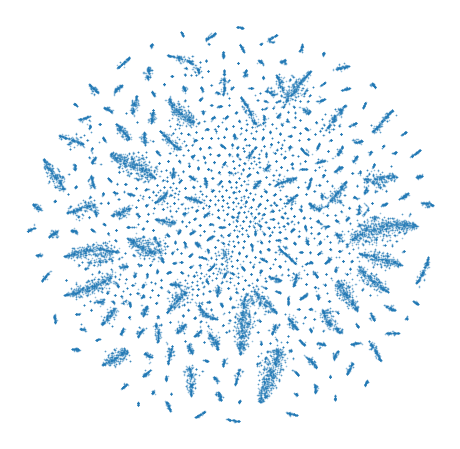

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

embeddings = np.array([w2v.wv.get_vector(node) for node in w2v.wv.vocab if node in paper_ids])
print(embeddings.shape)
embeddings_2D = TSNE(n_components=2).fit_transform(embeddings)
x = embeddings_2D[:,0]
y = embeddings_2D[:,1]
figure = plt.figure(figsize=(8, 8))
_ = plt.scatter(x, y, s=0.5, alpha=0.4)
_ = plt.axis('off')

For comparison, let's also run node2vec using the same parameter settings and visualize node2vec paper node embeddings.

In [10]:
import node2vec
import random
random.seed(a=42)
n2v = node2vec.Node2Vec(g, dimensions=100, num_walks=3, walk_length=10, workers=4)
n2v_model = n2v.fit(window=5, min_count=5)

Computing transition probabilities: 100%|██████████| 133008/133008 [00:03<00:00, 39398.71it/s]


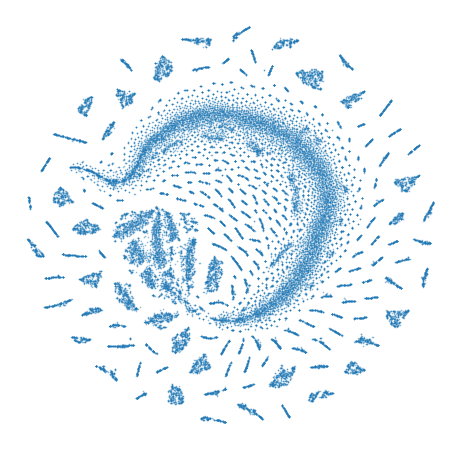

In [11]:
n2v_embeddings = np.array([n2v_model.wv.get_vector(node) for node in n2v_model.wv.vocab if node in paper_ids])
n2v_embeddings_2D = TSNE(n_components=2).fit_transform(n2v_embeddings)
x = n2v_embeddings_2D[:,0]
y = n2v_embeddings_2D[:,1]
figure = plt.figure(figsize=(8, 8))
_ = plt.scatter(x, y, s=0.5, alpha=0.4)
_ = plt.axis('off')

The result is a surprisingly "nice" picture which is quite difficult to compare with the result of metapath2vec as shown above. The only observation that we can make is that the number of outliers is much larger in the case of node2vec because the snake-shaped region in the middle consists of many data points while in the case of metapath2vec there are only few dispersed outliers and a large number of very tight, tiny clusters. In any case, the actual quality of embeddings in both cases can only be observed in downstream tasks which can be rigorously evaluated.